In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import albumentations as A
from tqdm import tqdm
import pandas as pd
import shutil

In [2]:



# Configuration
IMAGE_SIZE = 600
BATCH_SIZE = 8
NUM_CLASSES = 5
RANDOM_STATE = 42

In [3]:
# tang tuong phan cuc bo
def apply_CLAHE(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

# chinh sang toi
def adjust_gamma(img, gamma=1.5):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)
# tang tuong phan toan cuc
def global_hist_equal(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
# lam min vien
def smooth_bilateral(img):
    return cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

def addWeighted(img,sigmaX=10):
    return cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), sigmaX), -4, 128)
    
def enhance_fundus(img):
    img = apply_CLAHE(img)
    img = adjust_gamma(img, gamma=1.2)
    # img = cv2.GaussianBlur(img, (3, 3), 0)
    return img
def enhance_fundus2(img):
    img = apply_CLAHE(img)
    img = adjust_gamma(img, gamma=2)
    
    img = global_hist_equal(img)
    img = smooth_bilateral(img)
    return img

def crop_black(img, tol=7):
# ham xoa khoang den
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        
        if check_shape == 0:
            return img
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
            return img

def circle_crop(img, sigmaX=10):
# cat theo hinh tron
    height, width, depth = img.shape
    
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))
    
    height, width, depth = img.shape
    
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    
    img = cv2.bitwise_and(img, img, mask=circle_img)
    return img

def random_crop(img, size=(0.9, 1)):
    height, width, depth = img.shape
    
    cut = 1 - random.uniform(size[0], size[1])
    
    i = random.randint(0, int(cut * height))
    j = random.randint(0, int(cut * width))
    h = i + int((1 - cut) * height)
    w = j + int((1 - cut) * width)
    
    img = img[i:h, j:w, :]
    
    return img

def prepare_image(path, sigmaX=10, do_random_crop=False):
    
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # cat den
    image = crop_black(image, tol=7)
    if do_random_crop:
        image = random_crop(image, size=(0.9, 1))
    
    # Resize and color enhancement
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))  
    image = addWeighted(image)
    
    #cat tron
    image = circle_crop(image, sigmaX=sigmaX)
    
    # # Normalize to [0, 1]
    # image = image.astype(np.float32) / 255.0
    
    return image


In [4]:
 # Bước 1: Đọc ảnh và chuyển sang RGB
image = cv2.imread("train/10_left.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

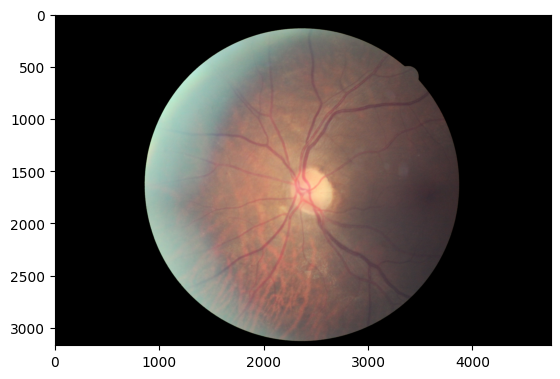

In [5]:
plt.imshow(image)

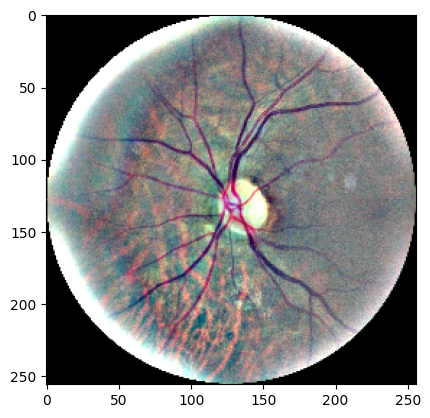

In [41]:
plt.imshow( prepare_image("train/10_left.jpeg"))

In [6]:
# pre process thu muc train
input_dir = 'train'
output_dir = 'train_preprocessed'

os.makedirs(output_dir, exist_ok=True)

# Lặp qua từng file ảnh
for filename in tqdm(os.listdir(input_dir)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        try:
            processed_img = prepare_image(input_path)

            # Chuyển lại ảnh về  BGR để lưu bằng OpenCV
            processed_img_bgr = cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_path, processed_img_bgr)
        except Exception as e:
            print(f"Lỗi xử lý ảnh {filename}: {e}")

  0%|          | 104/34126 [00:16<1:28:16,  6.42it/s]


KeyboardInterrupt: 

In [45]:
# pre process thu muc validation
input_dir = 'validation'
output_dir = 'validation_preprocessed'

os.makedirs(output_dir, exist_ok=True)

# Lặp qua từng file ảnh
for filename in tqdm(os.listdir(input_dir)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        try:
            processed_img = prepare_image(input_path)

            # Chuyển lại ảnh về  BGR để lưu bằng OpenCV
            processed_img_bgr = cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_path, processed_img_bgr)
        except Exception as e:
            print(f"Lỗi xử lý ảnh {filename}: {e}")

100%|██████████| 1000/1000 [02:33<00:00,  6.52it/s]


In [3]:
# hafm tawng cuong anh
def get_augmentations():
    return A.Compose([
        A.Rotate(limit=360, p=0.8), #xoay
        # A.Affine(shear=(2, 10), p=0.5),# xien meo
        A.HorizontalFlip(p=0.5),# lap
        A.VerticalFlip(p=0.5),
       A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.9, 0.95), size=(IMAGE_SIZE, IMAGE_SIZE), p=0.5),# cat trong khoang random
        A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=0, p=0.5),# dich chuyen 2% chieu rong ,cao . thay doi kich thuoc 10%
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),#  Krizhevsky color augmentation: thay đổi tông màu sắc
        # A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.3),# lam bien dang 
        A.Affine(translate_px=(-10, 10), p=0.5)# tinh tien theo truc  xy 
    ])

In [4]:

# xem truoc 36 anh (da bao gom 1 anh goc + 35 anh)
def visualize_augmentations(image_path, n=35):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Không thể đọc ảnh: {image_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    augment = get_augmentations()

    images = [image]  # chứa ảnh gốc
    for _ in range(n):
        augmented = augment(image=image)
        images.append(augmented['image'])

    # Hiển thị ảnh
    rows = 6
    cols = 6
    fig, axs = plt.subplots(rows, cols, figsize=(18, 18))
    fig.suptitle("Ảnh gốc + 35 ảnh sau tăng cường", fontsize=20)

    for i in range(rows * cols):
        ax = axs[i // cols, i % cols]
        if i < len(images):
            img = images[i]
            if isinstance(img, np.ndarray):
                display_img = img
            else:  # nếu là tensor
                display_img = img.permute(1, 2, 0).cpu().numpy()
            display_img = np.clip(display_img, 0, 255).astype(np.uint8)
            ax.imshow(display_img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()





/tmp/ipykernel_4608/1002437412.py:8: UserWarning: Argument(s) 'height, width' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.9, 0.95), size=(IMAGE_SIZE, IMAGE_SIZE), p=0.5),# cat trong khoang random


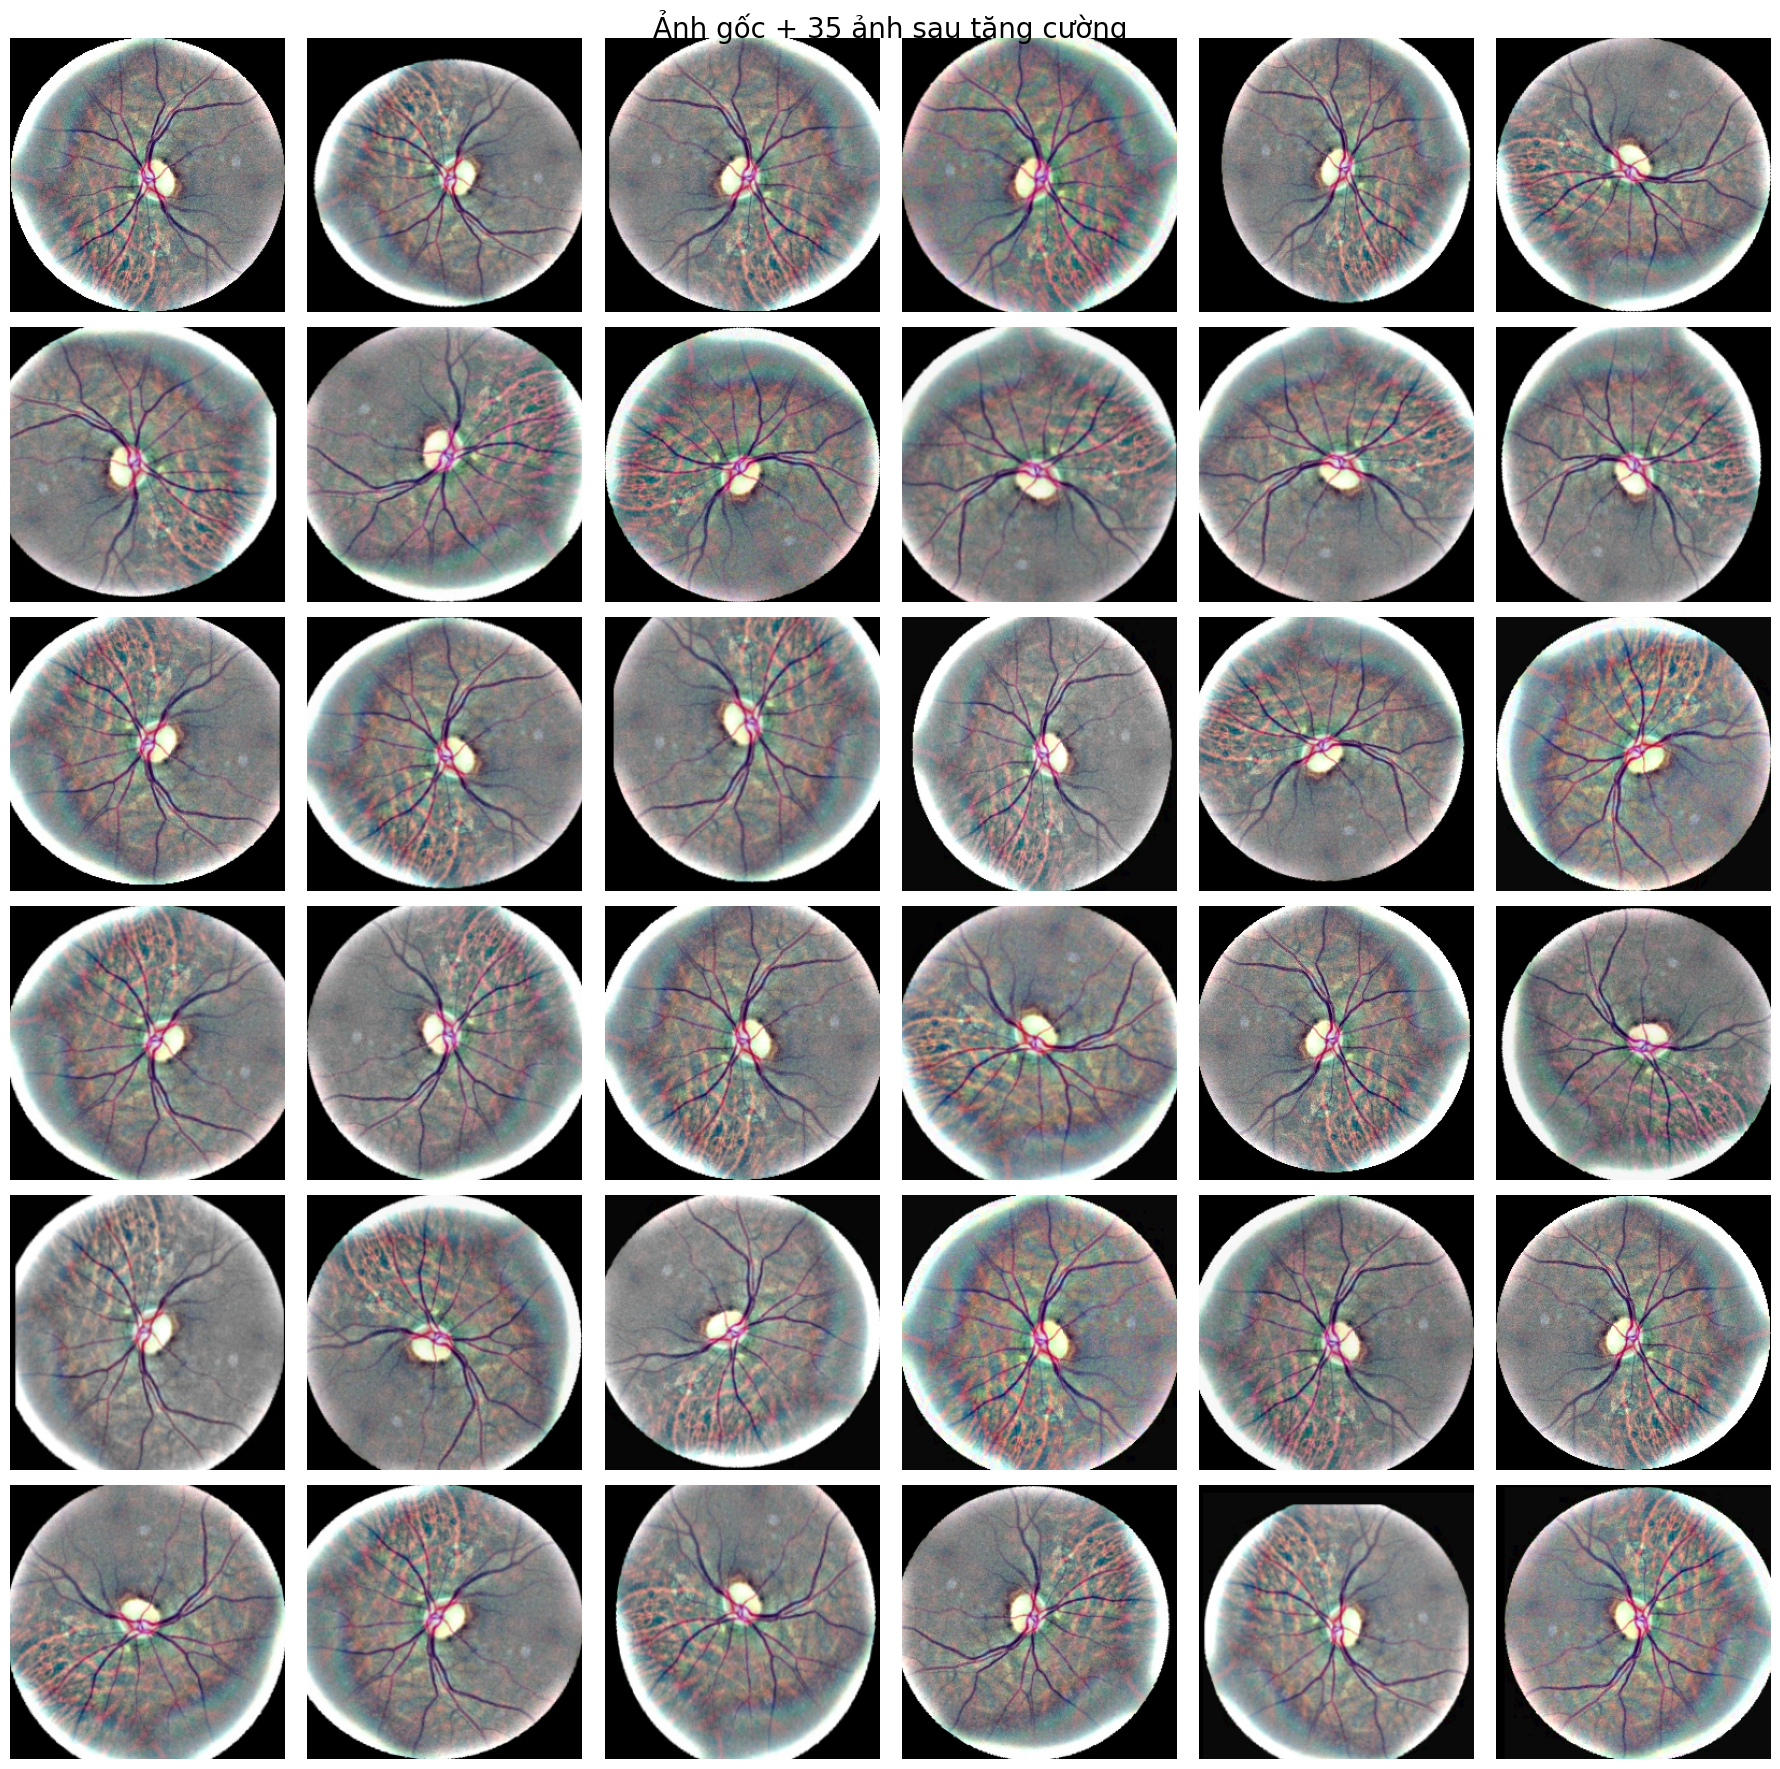

In [17]:
visualize_augmentations("train_preprocessed/10_left.jpeg", n=35)

In [18]:
def augment_images(n, label, csv_path="trainLabels/train_updated.csv", image_dir="train_preprocessed", output_dir="train_preprocessed_augmented"):
   # Load file CSV
    df = pd.read_csv(csv_path)

    # Lọc các ảnh có nhãn cần tăng cường
    target_df = df[df['level'] == label]

    os.makedirs(output_dir, exist_ok=True)

    augment = get_augmentations()

    new_data = []

    # Lặp qua từng ảnh
    for idx, row in tqdm(target_df.iterrows(), total=len(target_df)):
        image_path = os.path.join(image_dir, row['image'] + ".jpeg")
        image = cv2.imread(image_path)
        if image is None:
            print(f"Không thể đọc ảnh: {image_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Lưu ảnh gốc
        original_output_path = os.path.join(output_dir, row['image'] + ".jpeg")
        cv2.imwrite(original_output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        new_data.append([row['image'], label])

        # Tăng cường dữ liệu n lần
        for i in range(n):
            augmented = augment(image=image)
            aug_img = augmented['image']

            new_filename = f"{row['image']}_aug{i}.jpeg"
            save_path = os.path.join(output_dir, new_filename)

            cv2.imwrite(save_path, aug_img)
            new_data.append([new_filename[:-5], label])

    # Cập nhật CSV
    new_df = pd.DataFrame(new_data, columns=['image', 'level'])
    if os.path.exists("augmented_labels.csv"):
        new_df.to_csv("augmented_labels.csv", mode='a', index=False, header=False)
    else:
        new_df.to_csv("augmented_labels.csv", index=False)

In [19]:
# tang cuong label 1 Mild
augment_images(n=11,label=1)

/tmp/ipykernel_4608/1002437412.py:8: UserWarning: Argument(s) 'height, width' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.9, 0.95), size=(IMAGE_SIZE, IMAGE_SIZE), p=0.5),# cat trong khoang random
/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/2243 [00:00<?, ?it/s]

100%|██████████| 2243/2243 [00:48<00:00, 46.34it/s]


In [20]:
# tang cuong label 2 Moderate
augment_images(n=4,label=2)


/tmp/ipykernel_4608/1002437412.py:8: UserWarning: Argument(s) 'height, width' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.9, 0.95), size=(IMAGE_SIZE, IMAGE_SIZE), p=0.5),# cat trong khoang random
/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/5092 [00:00<?, ?it/s]

100%|██████████| 5092/5092 [00:48<00:00, 104.95it/s]


In [21]:
# tang cuong label 3 Severe
augment_images(n=20,label=3)


/tmp/ipykernel_4608/1002437412.py:8: UserWarning: Argument(s) 'height, width' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.9, 0.95), size=(IMAGE_SIZE, IMAGE_SIZE), p=0.5),# cat trong khoang random
/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/673 [00:00<?, ?it/s]

100%|██████████| 673/673 [00:34<00:00, 19.75it/s]


In [22]:
# tang cuong label 4 Proliferative DR

augment_images(n=30,label=4)


/tmp/ipykernel_4608/1002437412.py:8: UserWarning: Argument(s) 'height, width' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, scale=(0.9, 0.95), size=(IMAGE_SIZE, IMAGE_SIZE), p=0.5),# cat trong khoang random
/home/duc/Documents/DoAn/myvenv/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
  0%|          | 0/508 [00:00<?, ?it/s]

100%|██████████| 508/508 [00:36<00:00, 14.10it/s]


In [23]:
df = pd.read_csv('augmented_labels.csv')
df['level'].value_counts()

level
1    26916
2    25460
4    15748
3    14133
Name: count, dtype: int64

In [24]:
df['level']

0        1
1        1
2        1
3        1
4        1
        ..
82252    4
82253    4
82254    4
82255    4
82256    4
Name: level, Length: 82257, dtype: int64

In [25]:
def move_class_0_to_augmented( csv_path="trainLabels/train_updated.csv", image_dir="train_preprocessed", output_dir="train_preprocessed_augmented"):
    df = pd.read_csv(csv_path)
    class_0_df = df[df['level'] == 0]

    
    moved_data = []

    for idx, row in tqdm(class_0_df.iterrows(), total=len(class_0_df)):
        src_path = os.path.join(image_dir, row['image'] + ".jpeg")
        dst_path = os.path.join(output_dir, row['image'] + ".jpeg")
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
            moved_data.append([row['image'], 0])
        else:
            print(f"Không tìm thấy: {src_path}")

    if moved_data:
        moved_df = pd.DataFrame(moved_data, columns=["image", "level"])
        if os.path.exists("augmented_labels.csv"):
            moved_df.to_csv("augmented_labels.csv", mode='a', index=False, header=False)
        

In [26]:
move_class_0_to_augmented()

  0%|          | 0/25610 [00:00<?, ?it/s]

100%|██████████| 25610/25610 [00:18<00:00, 1361.61it/s]


In [27]:
df = pd.read_csv('augmented_labels.csv')
df['level'].value_counts()


level
1    26916
0    25610
2    25460
4    15748
3    14133
Name: count, dtype: int64